In [2]:
cd dockerdata/PySR/

/dockerdata/PySR


/env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [33]:
#pinn
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def exact_solution(d, w0, t):
    # 定义欠阻尼谐振子问题的解析解
    assert d < w0  # 确保阻尼系数d小于自然频率w0
    w = np.sqrt(w0**2 - d**2)  # 计算欠阻尼频率
    phi = np.arctan(-d/w)  # 计算初始相位
    A = 1/(2*np.cos(phi))  # 计算振幅
    cos = torch.cos(phi + w * t)  # 计算余弦项
    exp = torch.exp(-d * t)  # 计算指数衰减项
    u = exp * 2 * A * cos  # 计算解
    return u

class FCN(nn.Module):
    # 定义一个全连接神经网络（FCN）类
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh  # 使用双曲正切作为激活函数
        # 第一层全连接层，从输入层到隐藏层
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        # 中间隐藏层，可能有多层
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        # 最后一层全连接层，从隐藏层到输出层
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        # 定义网络的前向传播过程
        x = self.fcs(x)  # 通过第一层全连接层
        x = self.fch(x)  # 通过中间隐藏层
        x = self.fce(x)  # 通过最后一层全连接层
        return x

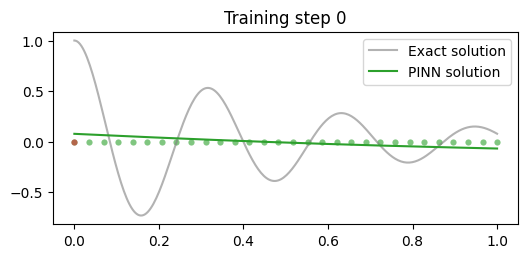

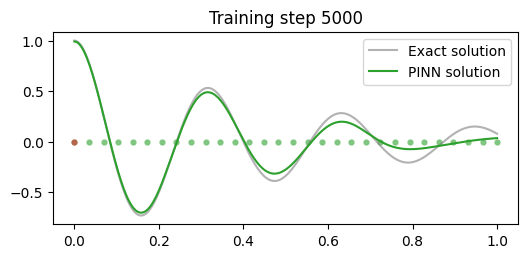

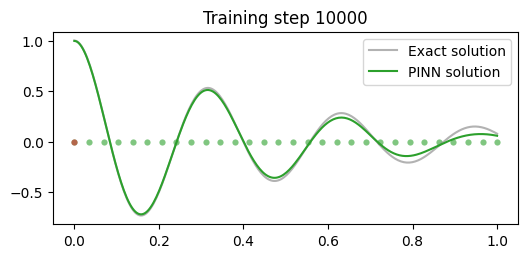

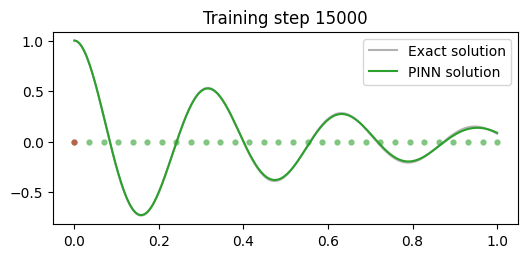

In [34]:
torch.manual_seed(123)  # 设置随机种子以确保实验可重复性

# 定义一个神经网络用于训练
pinn = FCN(1, 1, 32, 3)  # 创建一个输入和输出都是1维，有3个隐藏层，每层32个神经元的全连接网络

# 定义边界点，用于边界损失计算
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)  # 创建一个单元素张量，值为0，形状为(1, 1)，需要计算梯度

# 定义域上的训练点，用于物理损失计算
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)  # 创建一个从0到1等间隔的30个点的张量，形状为(30, 1)，需要计算梯度

# 训练过程
d, w0 = 2, 20  # 定义某些物理参数
mu, k = 2 * d, w0 ** 2  # 根据给定的物理参数计算mu和k
t_test = torch.linspace(0, 1, 300).view(-1, 1)  # 创建一个测试点集，用于最后的可视化
u_exact = exact_solution(d, w0, t_test)  # 计算精确解，用于与PINN解进行对比
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)  # 使用Adam优化器

for i in range(15001):
    optimiser.zero_grad()  # 在每次迭代开始时清空梯度

    # 计算每项损失
    lambda1, lambda2 = 1e-1, 1e-4  # 设置损失函数中的超参数

    # 计算边界损失
    u = pinn(t_boundary)  # 使用神经网络计算边界点的输出
    loss1 = (torch.squeeze(u) - 1) ** 2  # 计算边界损失的第一部分
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]  # 计算边界点输出的时间导数
    loss2 = (torch.squeeze(dudt) - 0) ** 2  # 计算边界损失的第二部分

    # 计算物理损失
    u = pinn(t_physics)  # 使用神经网络计算物理点的输出
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]  # 计算物理点输出的时间导数
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]  # 计算物理点输出的二阶时间导数
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)  # 计算物理损失

    # 反向传播并更新参数
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3  # 计算总损失
    loss.backward()  # 反向传播
    optimiser.step()  # 更新网络参数

    # 每隔5000步绘制和展示训练结果
    if i % 5000 == 0: 
    # 使用训练好的神经网络 pinn 对测试点 t_test 进行预测，并使用 .detach() 从当前计算图中分离，便于后续处理
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
    # 在图表上以绿色散点图的形式绘制物理训练点，这些点的 y 值被设置为0，使其在x轴上显示
        plt.scatter(t_physics.detach()[:,0], 
                torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
    # 以类似的方式，以红色散点图的形式绘制边界训练点
        plt.scatter(t_boundary.detach()[:,0], 
                torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
    # 绘制精确解（如果可用）作为参考，通常用于比较神经网络的输出和理论上的精确解
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
    # 绘制神经网络预测的解决方案，以展示其在测试点上的表现
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




In [36]:
print(u.shape)
print(t_test.shape)

torch.Size([300, 1])
torch.Size([300, 1])


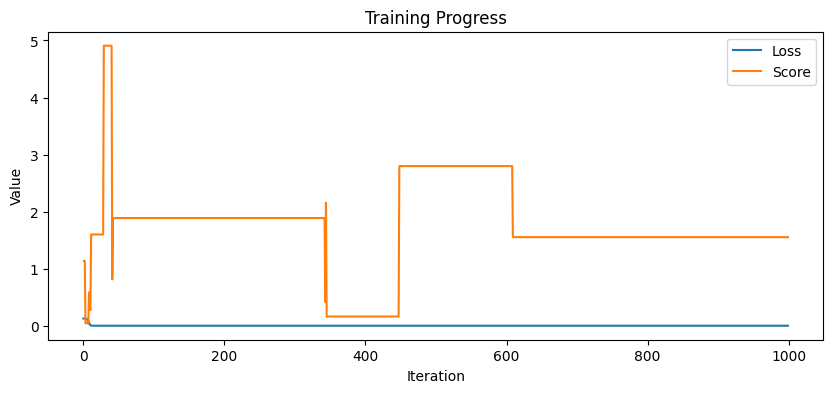

IntProgress(value=1000, description='Training:', max=1000)

In [37]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
from pysr import PySRRegressor
import pandas as pd

# 准备数据
X = t_test.numpy().reshape(-1, 1)
y = u.numpy().reshape(-1, 1)


# 初始化模型
model = PySRRegressor(
    procs=1,
    populations=3,
    niterations=1,  # 为了演示，我们每次只做一次迭代
    ncyclesperiteration=20,
    maxsize=300,
    parsimony=0.00001,
    unary_operators=["sin", "cos", "exp", "log"],
    warm_start = True,
)

# 准备绘图
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
progress_bar = widgets.IntProgress(value=0, min=0, max=1000, step=1, description='Training:')
display(progress_bar)

losses = []
scores = []

# 模拟的训练循环
for i in range(1000):
    model.fit(X, y)
    best_equation = model.get_best()
    loss = best_equation['loss']
    score = best_equation['score']
    losses.append(loss)
    scores.append(score)

    # 更新图表
    ax.clear()
    ax.plot(losses, label='Loss')
    ax.plot(scores, label='Score')
    ax.legend()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Value')
    ax.set_title('Training Progress')
    plt.show()

    # 更新进度条
    progress_bar.value += 1
    clear_output(wait=True)
    display(fig)
    display(progress_bar)



In [38]:
# 获取最佳方程的 SymPy 表达式和 Python 函数
best_equation_sympy = model.get_best()["equation"]
best_equation_func = model.get_best()["lambda_format"]

print("最佳方程（SymPy）:", best_equation_sympy)
print("最佳方程（Python）:", best_equation_func)
# 为绘制方程准备数据


最佳方程（SymPy）: (0.586471 * sin((sin(0.10063128) - (x0 + -0.30040115)) / sin(0.050542038))) * exp((0.2648488 - x0) / sin(cos(1.0436163)))
最佳方程（Python）: PySRFunction(X=>-1.01580837585667*exp(-2.07407691824154*x0)*sin(19.7939362183804*x0 - 7.93465018054415))


In [39]:
z_values = np.linspace(X.min(), X.max(), 500)
# 生成 z 值的二维数组版本，以满足 best_equation_func 的输入要求
z_values_2d = np.array([[z] for z in z_values])

# 计算 y 值
# 因为 best_equation_func 现在接收的是一个正确形状的二维数组，所以这里不会再出错
y_values = [best_equation_func(z) for z in z_values_2d]

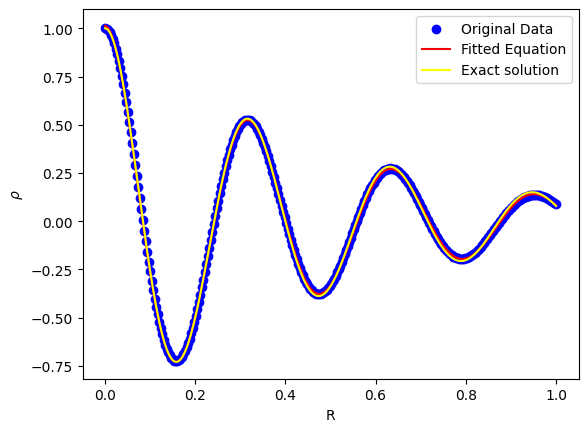

In [42]:
plt.scatter(X, y, color='blue', label='Original Data')
# 绘制方程图像
plt.plot(z_values, y_values, color='red', label='Fitted Equation')
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="yellow")
#plt.xscale('log')
#plt.yscale('log')
# 添加图例
plt.legend()

# 设置标签
plt.xlabel('R')
plt.ylabel(r'$\rho$')

# 显示图像
plt.show()